# Bibliotecas

In [177]:
# ! pip install xgboost

In [195]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split,
                                     cross_val_score)
from sklearn.metrics import (mean_squared_error,
                             r2_score,
                             mean_absolute_error)
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt

# Dataset

In [179]:
df = sns.load_dataset('mpg')

df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


É um problema regressão, pois a variável *target* 'mpg' é contínua

In [180]:
X = df.drop(['mpg', 'origin', 'name'],  axis=1) # Remove features categóricas

y = df['mpg']

## Split treino e teste

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

# Modelos de regressão

In [182]:
# Cross validation apenas para comparação entre modelos
reg_xgboost = xgb.XGBRegressor(objective='reg:squarederror')

resultado_cv = cross_val_score(reg_xgboost, X_train, y_train, scoring='neg_root_mean_squared_error')
# Uso do neg para buscar o erro "quanto menor, melhor"
# Caso contrário, o scikit-learn vai maximizar o erro, trazendo o maior valor, neste caso "quanto maior, pior", o que é indesejado

abs(resultado_cv.mean())

3.038932439871286

## Tunando o classificador

In [183]:
reg_xgboost_depth = xgb.XGBRegressor(max_depth=2, objective='reg:squarederror') # Altera a altura máxima das árvores

resultado_cv_depth = cross_val_score(reg_xgboost_depth, X_train, y_train, scoring='neg_root_mean_squared_error')

abs(resultado_cv_depth.mean())

3.0142666284856547

In [184]:
reg_xgboost_dart = xgb.XGBRegressor(booster='dart', objective='reg:squarederror')

resultado_cv_dart = cross_val_score(reg_xgboost_dart, X_train, y_train, scoring='neg_root_mean_squared_error')

abs(resultado_cv_dart.mean())

3.0389324072832244

In [185]:
reg_xgboost_gblinear = xgb.XGBRegressor(booster='gblinear', objective='reg:squarederror')

resultado_cv_gblinear = cross_val_score(reg_xgboost_gblinear, X_train, y_train, scoring='neg_root_mean_squared_error')

abs(resultado_cv_gblinear.mean())

4.714230104740481

In [186]:
reg_xgboost_gbtree = xgb.XGBRegressor(booster='gbtree', objective='reg:squarederror')

resultado_cv_gbtree = cross_val_score(reg_xgboost_gbtree, X_train, y_train, scoring='neg_root_mean_squared_error')

abs(resultado_cv_gbtree.mean())

3.038932439871286

# Aplicação do melhor modelo

In [187]:
melhor_modelo = reg_xgboost_depth

melhor_modelo = xgb.XGBRegressor(eval_metric='rmse', objective='reg:squarederror')

melhor_modelo.fit(X_train, y_train)

XGBRegressor(eval_metric='rmse', objective='reg:squarederror')

In [188]:
y_pred = melhor_modelo.predict(X_test)

# Acurácia

In [189]:
rmse = sqrt(mean_squared_error(y_test, y_pred))

r_squared = r2_score(y_test, y_pred)

mae = mean_absolute_error(y_test, y_pred)

print('RMSE = {} \
       R^2 = {} \
       MAE = {}'.format(rmse,
                        r_squared,
                        mae))

RMSE = 2.8271321650739645        R^2 = 0.8749226791335302        MAE = 2.012123066584269


# mpg para km/L

In [190]:
y_pred_all = melhor_modelo.predict(X)

df['mpg_pred'] = y_pred_all

df['mpg_pred'] = df['mpg_pred'].round(2)

In [191]:
rmse = sqrt(mean_squared_error(y, y_pred_all))

r_squared = r2_score(y, y_pred_all)

mae = mean_absolute_error(y, y_pred_all)

print('RMSE = {} \
       R^2 = {} \
       MAE = {}'.format(rmse,
                        r_squared,
                        mae))

RMSE = 1.9841994625012171        R^2 = 0.9353905770031276        MAE = 1.3842332312809162


In [192]:
mpg_para_kml = 0.425144

df['km_l'] = round(df['mpg'] * mpg_para_kml, 2)

df['km_l_pred'] = round(df['mpg_pred'] * mpg_para_kml, 2)

In [193]:
reorder_columns = ['mpg',
                   'km_l',
                   'mpg_pred',
                   'km_l_pred',
                   'cylinders',
                   'displacement',
                   'horsepower',
                   'weight',
                   'acceleration',
                   'model_year',
                   'origin',
                   'name']

df = df.reindex(columns=reorder_columns, copy=True)

df

,mpg,km_l,mpg_pred,km_l_pred,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,7.65,16.270000,6.920000,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,6.38,15.390000,6.540000,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,7.65,16.110001,6.850000,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,6.80,15.860000,6.740000,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,7.23,16.080000,6.840000,8,302.0,140.0,3449,10.5,70,usa,ford torino
...,...,...,...,...,...,...,...,...,...,...,...,...
393,27.0,11.48,26.660000,11.330000,4,140.0,86.0,2790,15.6,82,usa,ford mustang gl
394,44.0,18.71,43.770000,18.610001,4,97.0,52.0,2130,24.6,82,europe,vw pickup
395,32.0,13.60,32.110001,13.650000,4,135.0,84.0,2295,11.6,82,usa,dodge rampage
396,28.0,11.90,29.299999,12.460000,4,120.0,79.0,2625,18.6,82,usa,ford ranger


# Análise gráfica

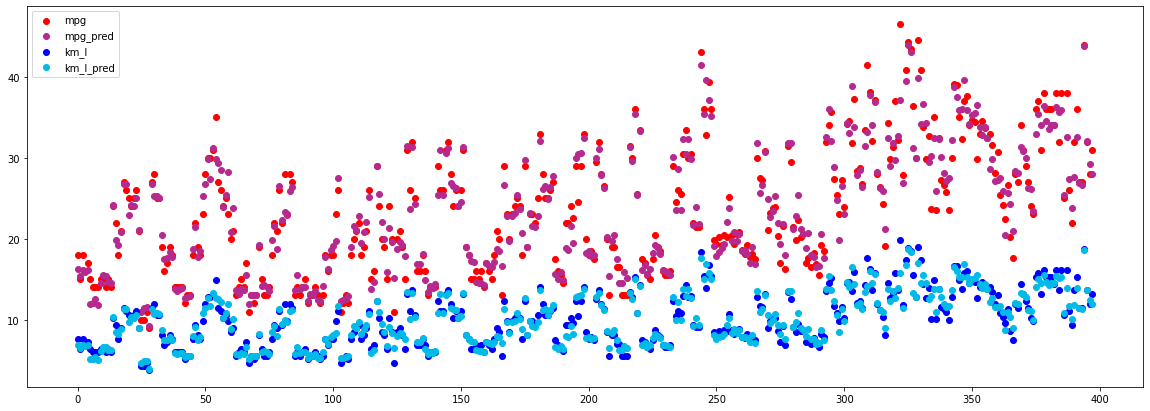

In [203]:
plt.figure(figsize=(20, 7))

plt.scatter(y=df['mpg'], x=df.index, color='#FF0000', label='mpg')
plt.scatter(y=df['mpg_pred'], x=df.index, color='#B62A8F', label='mpg_pred')
plt.scatter(y=df['km_l'], x=df.index, color='#0000FF', label='km_l')
plt.scatter(y=df['km_l_pred'], x=df.index, color='#00BBE7', label='km_l_pred')

plt.legend()